# CNN + LSTM Model for Predicting Cryptocurrency Value
In this model LSTM and CNN layers are combined for predicting the cryptocurrency time series. This combination allows for the LSTM layer to account for sequential dependencies in the time series, while the CNN layer further informs this process through the use of dilated convolutions.The goal of this model was to compare the result with the other model which does not have any CNN layer. 

The result of this model shows a high mean absolute error which convince us prediction with LSTM and without CNN performs better. 

In [ ]:
# importing main libraries and packages 


import numpy as np
import pandas as pd 
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.models import Sequential
import datetime as dt
import pandas_datareader as web   # for scraping data from yahoo in terms of a dataframe


In [ ]:
c = 'BTC'
a = 'USD'


s = dt.datetime(2015,1,1)
e = dt.datetime.now()
data = web.DataReader(f'{c}-{a}', 'yahoo',s,e)

In [ ]:
data.head()


,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-01-01,320.434998,314.002991,320.434998,314.248993,8036550.0,314.248993
2015-01-02,315.838989,313.565002,314.079010,315.032013,7860650.0,315.032013
2015-01-03,315.149994,281.082001,314.846008,281.082001,33054400.0,281.082001
2015-01-04,287.230011,257.612000,281.145996,264.195007,55629100.0,264.195007
2015-01-05,278.341003,265.084015,265.084015,274.473999,43962800.0,274.473999


In [ ]:
data['Date'] = data.index 

data = data.reset_index(drop= True)


In [ ]:
data.head()

,High,Low,Open,Close,Volume,Adj Close,Date
0,320.434998,314.002991,320.434998,314.248993,8036550.0,314.248993,2015-01-01
1,315.838989,313.565002,314.079010,315.032013,7860650.0,315.032013,2015-01-02
2,315.149994,281.082001,314.846008,281.082001,33054400.0,281.082001,2015-01-03
3,287.230011,257.612000,281.145996,264.195007,55629100.0,264.195007,2015-01-04
4,278.341003,265.084015,265.084015,274.473999,43962800.0,274.473999,2015-01-05


In [ ]:
df1 = data[['Date','Close']] 

In [ ]:
df1.head()

,Date,Close
0,2015-01-01,314.248993
1,2015-01-02,315.032013
2,2015-01-03,281.082001
3,2015-01-04,264.195007
4,2015-01-05,274.473999


In [ ]:
import tensorflow as tf
print(tf.__version__)

2.5.0


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
#plotting series
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

(2361,)

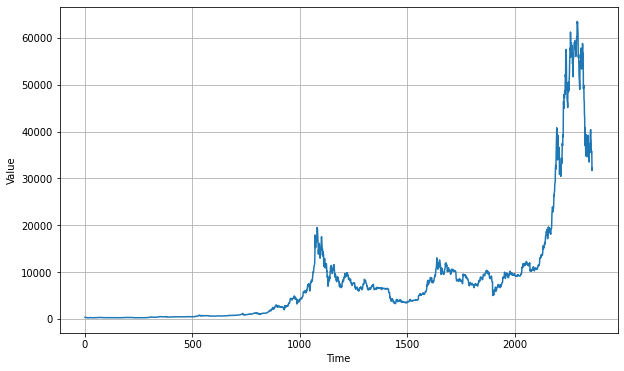

In [ ]:
# this is hows the data looks like 

temps = df1.iloc[:,1]
temps.shape
#print(time)
series = np.array(temps)
time = np.array(range(0,len(temps)))
plt.figure(figsize=(10, 6))
plot_series(time, series)
series.shape

In [ ]:
#spliting data 
split_time = 2000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 64
shuffle_buffer_size = 2000


In [ ]:
# function to get windowed or sliced data for effiecient results
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [ ]:
# forecasting model 
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [ ]:
# CNN+lSTM Model 
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 20
batch_size = 64
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1)
#  tf.keras.layers.Lambda(lambda x: x * 40000)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 20**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=50, callbacks=[lr_schedule])


(1e-08, 0.0001, 0.0, 6000.0)

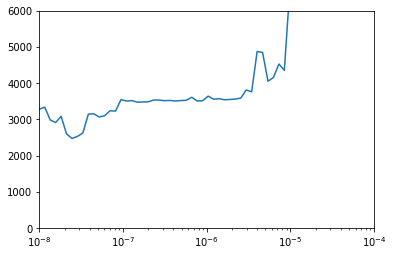

In [ ]:
#analysing the optimum learning rate and choosing that optimum

plt.semilogx(history.history["lr"], history.history["loss"])

plt.axis([1e-8, 1e-4, 0, 6000])

In [ ]:
#model learning 

tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=40, batch_size=64, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=50, kernel_size=5,
                       strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(30, return_sequences=True),
  tf.keras.layers.LSTM(30, return_sequences=True),
  tf.keras.layers.Dense(15, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1)
 # tf.keras.layers.Lambda(lambda x: x * 40000)   # scaled the values with the averaged price that time (always changeable ) 
])

optimizer = tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=50)

Epoch 1/50
31/31 [==============================] - 4s 38ms/step - loss: 3869.2678 - mae: 3869.7678
Epoch 2/50
31/31 [==============================] - 1s 38ms/step - loss: 3517.0432 - mae: 3517.5430
Epoch 3/50
31/31 [==============================] - 1s 38ms/step - loss: 3515.8569 - mae: 3516.3564
Epoch 4/50
31/31 [==============================] - 1s 38ms/step - loss: 3563.8489 - mae: 3564.3486
Epoch 5/50
31/31 [==============================] - 1s 38ms/step - loss: 3547.3259 - mae: 3547.8257
Epoch 6/50
31/31 [==============================] - 1s 38ms/step - loss: 3601.5793 - mae: 3602.0796
Epoch 7/50
31/31 [==============================] - 1s 38ms/step - loss: 3592.9448 - mae: 3593.4448
Epoch 8/50
31/31 [==============================] - 1s 38ms/step - loss: 3543.1082 - mae: 3543.6086
Epoch 9/50
31/31 [==============================] - 1s 38ms/step - loss: 3558.2852 - mae: 3558.7854
Epoch 10/50
31/31 [==============================] - 1s 38ms/step - loss: 3524.6851 - mae: 3525.1848

(10.0, 50.0, 0.0, 6000.0)

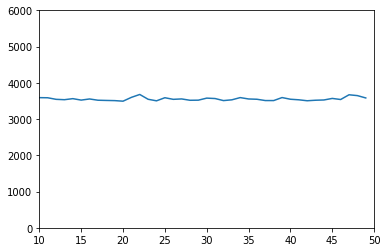

In [ ]:
plt.plot(history.history["loss"])
plt.axis([10,50,0,6000])

In [ ]:
# rnn forecasting
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]
rnn_forecast

array([2036.0557, 2036.0557, 2036.0557, 2036.0557, 2036.0557, 2036.0557,
       2036.0557, 2036.0557, 2036.0557, 2036.0557, 2036.0557, 2036.0557,
       2036.0557, 2036.0557, 2036.0557, 2036.0557, 2036.0557, 2036.0557,
       2036.0557, 2036.0557, 2036.0557, 2036.0557, 2036.0557, 2036.0557,
       2036.0557, 2036.0557, 2036.0557, 2036.0557, 2036.0557, 2036.0557,
       2036.0557, 2036.0557, 2036.0557, 2036.0557, 2036.0557, 2036.0557,
       2036.0557, 2036.0557, 2036.0557, 2036.0557, 2036.0557, 2036.0557,
       2036.0557, 2036.0557, 2036.0557, 2036.0557, 2036.0557, 2036.0557,
       2036.0557, 2036.0557, 2036.0557, 2036.0557, 2036.0557, 2036.0557,
       2036.0557, 2036.0557, 2036.0557, 2036.0557, 2036.0557, 2036.0557,
       2036.0557, 2036.0557, 2036.0557, 2036.0557, 2036.0557, 2036.0557,
       2036.0557, 2036.0557, 2036.0557, 2036.0557, 2036.0557, 2036.0557,
       2036.0557, 2036.0557, 2036.0557, 2036.0557, 2036.0557, 2036.0557,
       2036.0557, 2036.0557, 2036.0557, 2036.0557, 

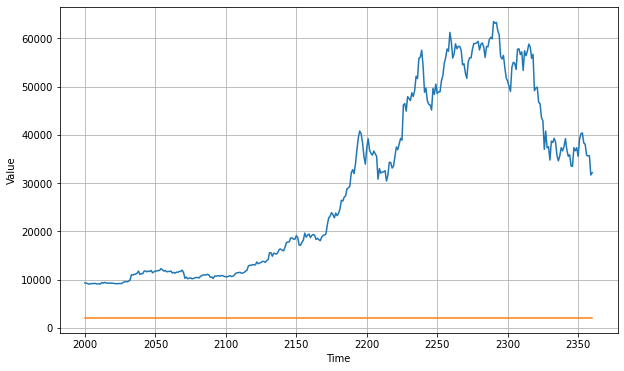

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()                   

27310.299

In [ ]:
print(rnn_forecast)

[2036.0557 2036.0557 2036.0557 2036.0557 2036.0557 2036.0557 2036.0557
 2036.0557 2036.0557 2036.0557 2036.0557 2036.0557 2036.0557 2036.0557
 2036.0557 2036.0557 2036.0557 2036.0557 2036.0557 2036.0557 2036.0557
 2036.0557 2036.0557 2036.0557 2036.0557 2036.0557 2036.0557 2036.0557
 2036.0557 2036.0557 2036.0557 2036.0557 2036.0557 2036.0557 2036.0557
 2036.0557 2036.0557 2036.0557 2036.0557 2036.0557 2036.0557 2036.0557
 2036.0557 2036.0557 2036.0557 2036.0557 2036.0557 2036.0557 2036.0557
 2036.0557 2036.0557 2036.0557 2036.0557 2036.0557 2036.0557 2036.0557
 2036.0557 2036.0557 2036.0557 2036.0557 2036.0557 2036.0557 2036.0557
 2036.0557 2036.0557 2036.0557 2036.0557 2036.0557 2036.0557 2036.0557
 2036.0557 2036.0557 2036.0557 2036.0557 2036.0557 2036.0557 2036.0557
 2036.0557 2036.0557 2036.0557 2036.0557 2036.0557 2036.0557 2036.0557
 2036.0557 2036.0557 2036.0557 2036.0557 2036.0557 2036.0557 2036.0557
 2036.0557 2036.0557 2036.0557 2036.0557 2036.0557 2036.0557 2036.0557
 2036.